# Data Exploration 

Here we want to simply show the raw pattern on:
- Frames of bees growth
- Frames of brood growth 
- Frames of honey growth 
- Gentleness
- Varroa dynamic impact 
- Colonie survival
- Queen survival 

The output of this notebook is a grid chart for the annexe of the paper showing the cubee effect on different hive state attributes and prepare the formal modelisation.

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pandas as pd 
from scipy.stats import gmean

from matplotlib.offsetbox import AnchoredText
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import statsmodels.api as sm
import seaborn as sns
from cubee.configs.filepath import formatted_datapath, raw_datapath

plt.style.use('seaborn-v0_8-poster')

### 0. Load formatted dataset

In [2]:
data = pd.read_csv(formatted_datapath)
data['death'] = data["state"].apply(lambda x: True if x < 1 else False)
data.head(10)

,time1,time2,state,hive_age,cubee,fob,fobr,foh,varroa,queen_age,queen_state,queen_cubee,queen_id,brood_pattern,stings,hid,hive_interacted,death
0,0,30,1,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,0,False
1,30,59,1,39,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,0,False
2,59,89,1,74,0,NaN,2.300327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,0,False
3,89,118,1,98,0,6.61115,4.234924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,1,False
4,118,148,1,125,1,6.00000,6.316360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,1,False
5,148,178,1,150,0,6.00000,6.190872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,1,False
6,178,207,1,196,1,6.00000,6.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,46955,24,False
7,207,237,1,210,0,6.00000,6.000000,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,46955,23,False
8,0,30,1,278,0,6.00000,6.000000,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,46955,23,False
9,30,60,1,306,0,6.00000,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,23,False


### 0.1 distribution chart 

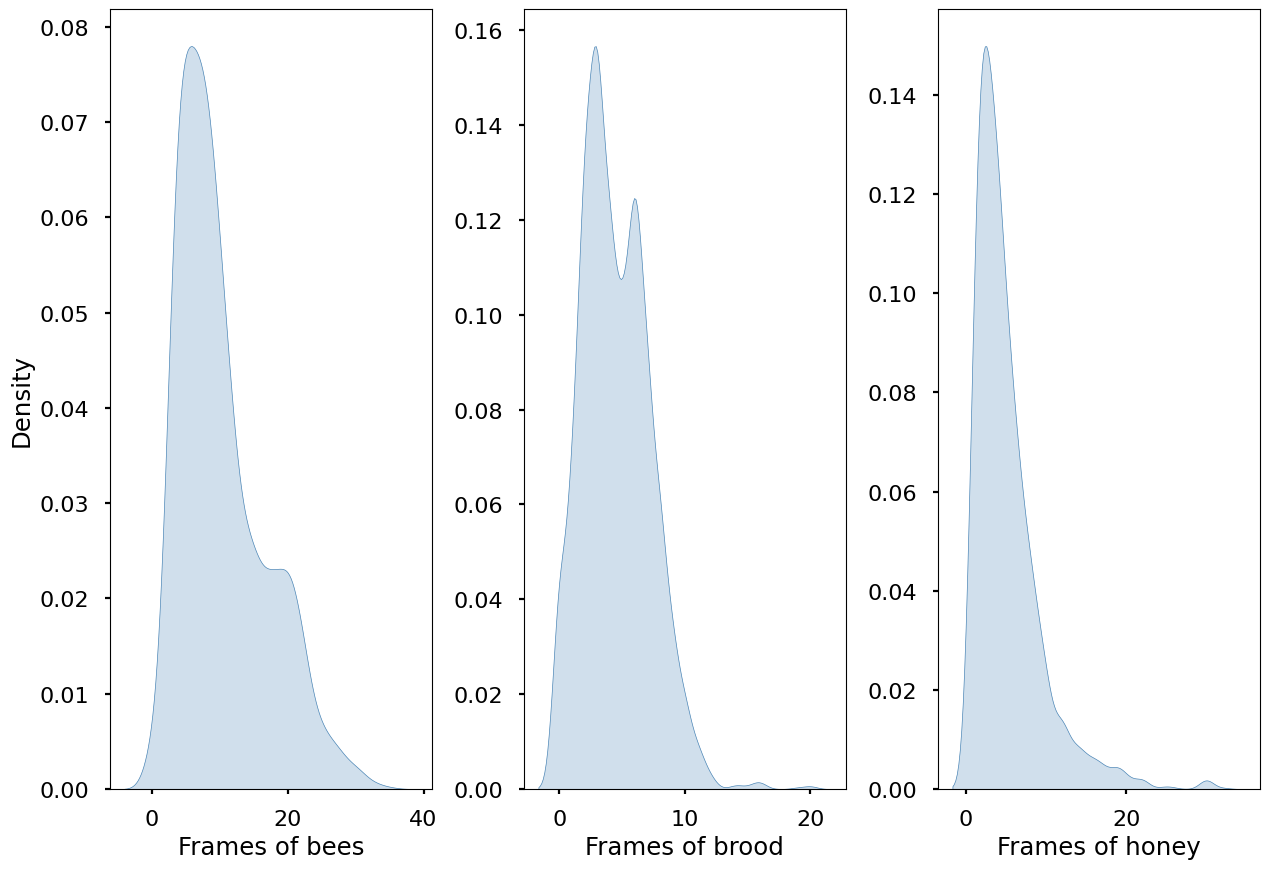

In [3]:
fig, axs = plt.subplots(1, 3)
ax = sns.kdeplot(data['fob'], fill=True,  color="steelblue",ax=axs[0])
ax.set_xlabel("Frames of bees")
ax = sns.kdeplot(data['fobr'],  fill=True,color="steelblue",ax=axs[1])
ax.set_xlabel("Frames of brood")
ax.set_ylabel("")
ax = sns.kdeplot(data['foh'],  fill=True,color="steelblue",ax=axs[2])
ax.set_xlabel("Frames of honey")
ax.set_ylabel("")
fig.tight_layout()
# sns.despine(left=True, bottom=True)
plt.savefig("num_distribution.png")

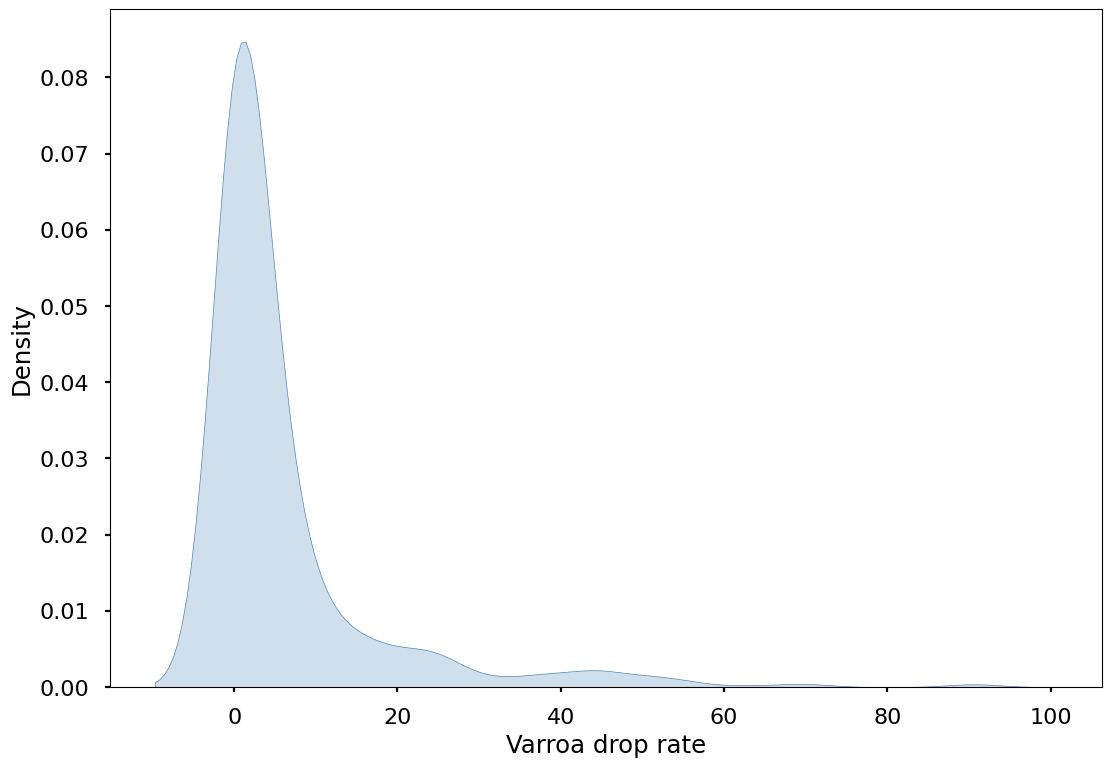

In [4]:
ax = sns.kdeplot(data['varroa'],  fill=True,color="steelblue")
ax.set_xlabel("Varroa drop rate")
ax.set_ylabel("Density")
fig.tight_layout()
# sns.despine(left=True, bottom=True)
plt.savefig("varroa_distribution.png")

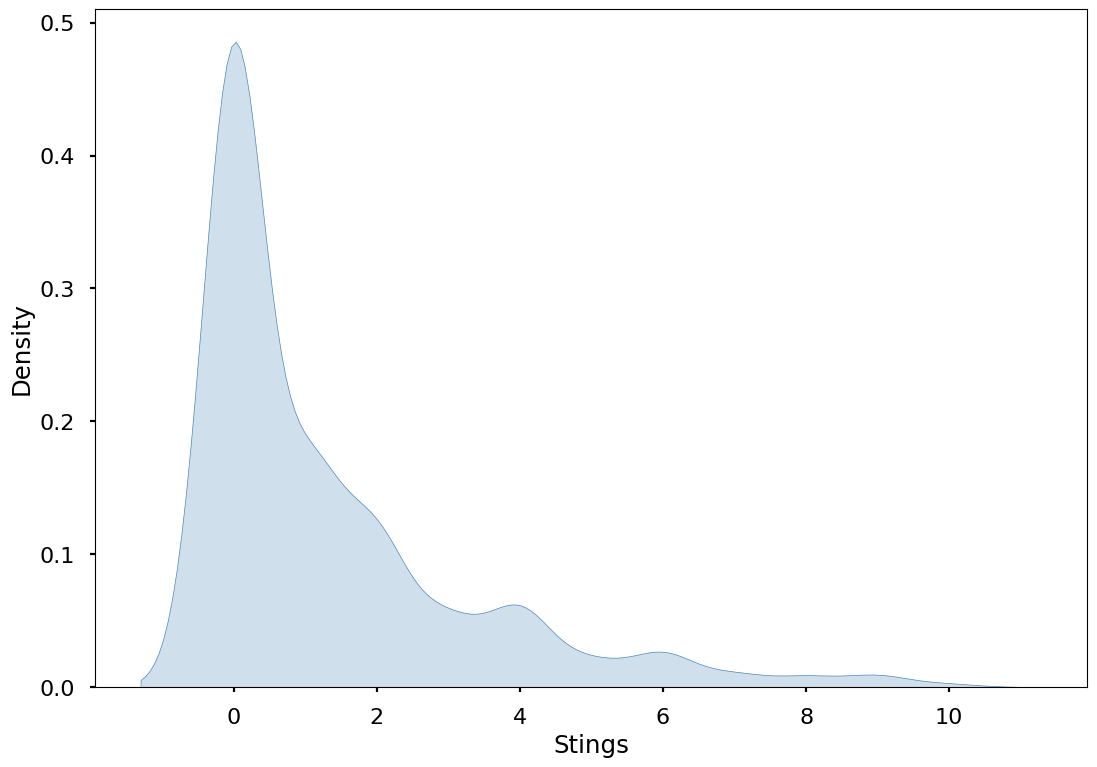

In [5]:
ax = sns.kdeplot(data['stings'],  fill=True,color="steelblue")
ax.set_xlabel("Stings")
ax.set_ylabel("Density")
fig.tight_layout()
# sns.despine(left=True, bottom=True)
plt.savefig("stings_distribution.png")

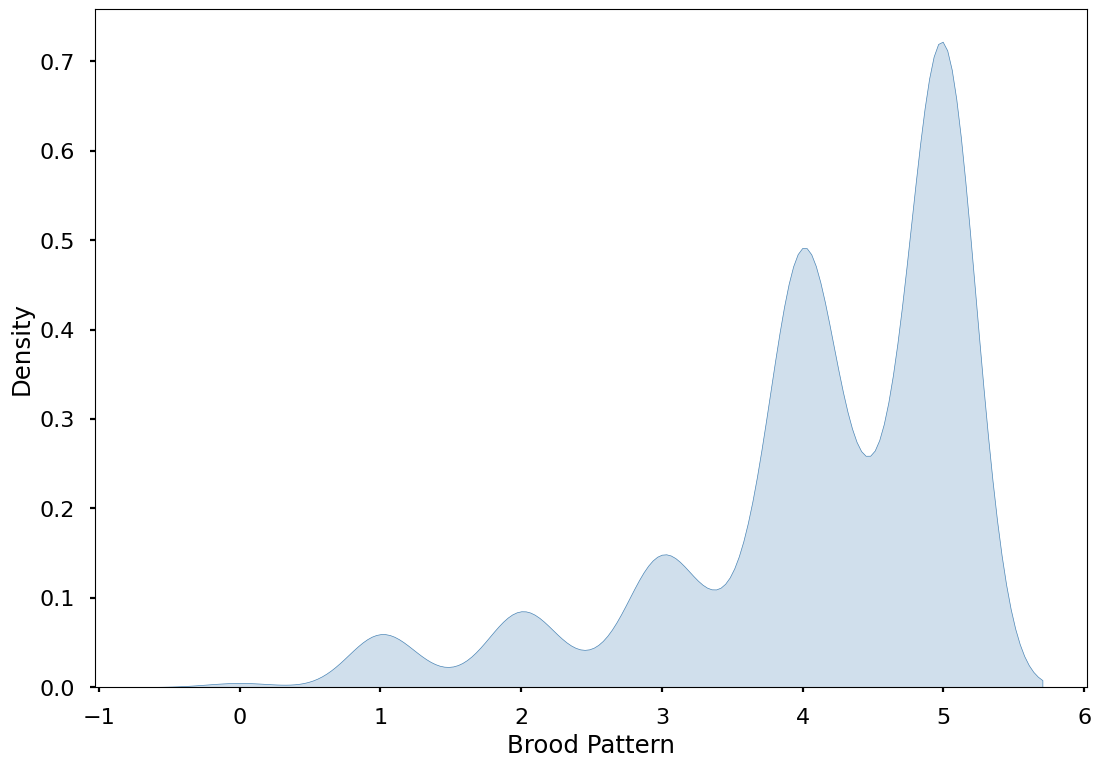

In [6]:
ax = sns.kdeplot(data['brood_pattern'],  fill=True,color="steelblue")
ax.set_xlabel("Brood Pattern")
ax.set_ylabel("Density")
fig.tight_layout()
# sns.despine(left=True, bottom=True)
plt.savefig("brood_pattern_distribution.png")

### From long to short for quick Kaplan Meier

In [7]:
cubee_dose = data.groupby("hid")['cubee'].sum().reset_index()
states = data.groupby("hid")[['death','hive_age']].max().reset_index()
short = pd.merge(states,cubee_dose,on="hid",how="left")
short['cubee'] = short['cubee'].fillna(0)


In [8]:
#sns.distplot(cubee_dose['cubee'])

### 1. Quick look at survival

In [9]:
cubeed = short.loc[short['cubee']>1.0]
not_cubeed = short.loc[short['cubee']==0.0]

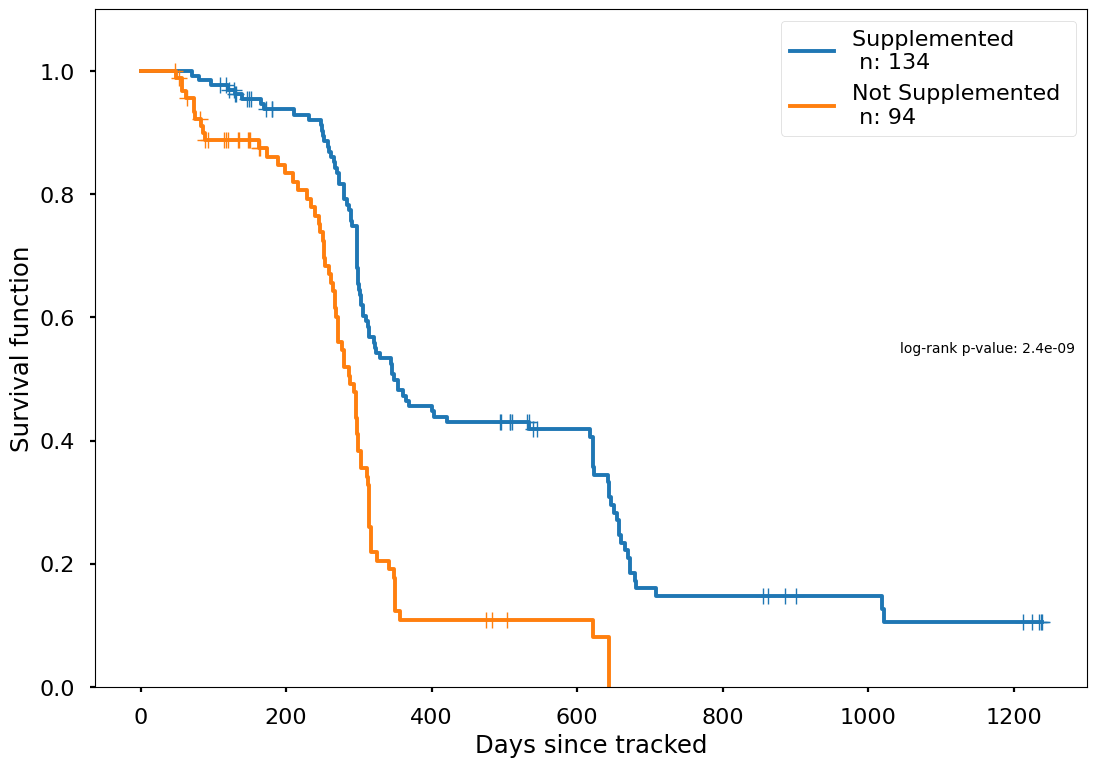

In [10]:
low_results=logrank_test(cubeed['hive_age'],not_cubeed['hive_age'],event_observed_A=cubeed['death'], event_observed_B=not_cubeed['death'])
kmf = KaplanMeierFitter()
ax = plt.subplot(111)
ax = kmf.fit(cubeed['hive_age'], cubeed['death'], label=f"Supplemented \n n: {len(cubeed)}").plot(ax=ax, ci_show=False, show_censors=True)
ax = kmf.fit(not_cubeed['hive_age'], not_cubeed['death'], label=f"Not Supplemented \n n: {len(not_cubeed)}").plot(ax=ax, ci_show=False, show_censors=True)
ax.set_xlabel('Days since tracked')
ax.set_ylabel('Survival function')
plt.ylim([0, 1.1])
anchored_text = AnchoredText("log-rank p-value: {:.3}".format(low_results.p_value), loc=5, frameon=False)
ax.add_artist(anchored_text)
plt.savefig("KM-Global-Survival-logRank.png")

In [11]:
cubee_dose = data.groupby("queen_id")['cubee'].sum().reset_index()
cubee_dose.head()


,queen_id,cubee
0,150993_queen_0,0
1,150993_queen_1,7
2,150993_queen_2,2
3,150995_queen_0,3
4,150996_queen_0,9


In [12]:
states = data.groupby("queen_id")[['queen_state','queen_age']].max().reset_index()
short = pd.merge(states,cubee_dose,on="queen_id",how="left")
short['cubee'] = short['cubee'].fillna(0)

In [13]:
cubeed = short.loc[short['cubee']>0.0]
not_cubeed = short.loc[short['cubee']==0.0]

/Users/nico/Library/Caches/pypoetry/virtualenvs/cubee-YeWUf-Zc-py3.11/lib/python3.11/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/nico/Library/Caches/pypoetry/virtualenvs/cubee-YeWUf-Zc-py3.11/lib/python3.11/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


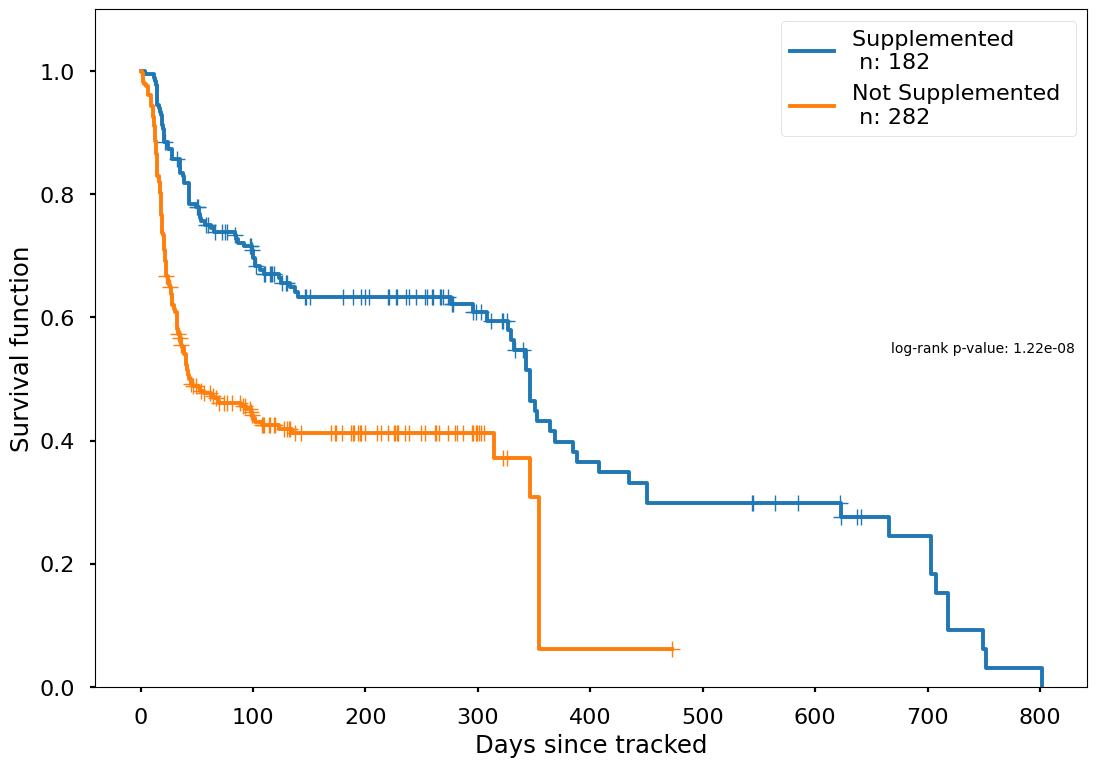

In [14]:
low_results=logrank_test(cubeed['queen_age'],not_cubeed['queen_age'],event_observed_A=cubeed['queen_state'], event_observed_B=not_cubeed['queen_state'])
kmf = KaplanMeierFitter()
ax = plt.subplot(111)
ax = kmf.fit(cubeed['queen_age'], cubeed['queen_state'], label=f"Supplemented \n n: {len(cubeed)}").plot(ax=ax, ci_show=False, show_censors=True)
ax = kmf.fit(not_cubeed['queen_age'], not_cubeed['queen_state'], label=f"Not Supplemented \n n: {len(not_cubeed)}").plot(ax=ax, ci_show=False, show_censors=True)
ax.set_xlabel('Days since tracked')
ax.set_ylabel('Survival function')
plt.ylim([0, 1.1])
anchored_text = AnchoredText("log-rank p-value: {:.3}".format(low_results.p_value), loc=5, frameon=False)
ax.add_artist(anchored_text)
plt.savefig("KM-Queen-Survival-logRank.png")

### 2. Quick look at global fob, fobr, foh, stings, brood_pattern and varroa 

#### 2.1 Fob growth following supplementation

In [15]:
EFFECT_LENGTH_IN_MONTH = 3

In [16]:
data['applied_previous_month'] = data.groupby("hid")['cubee'].rolling(EFFECT_LENGTH_IN_MONTH, min_periods=1).sum().reset_index()['cubee'].shift(-1)
data['applied_previous_month'] = data['applied_previous_month'].fillna(0)
data['delta_fob'] = data.groupby("hid")['fob'].pct_change(EFFECT_LENGTH_IN_MONTH)
data['delta_fobr'] = data.groupby("hid")['fobr'].pct_change(EFFECT_LENGTH_IN_MONTH)
data['delta_foh'] = data.groupby("hid")['foh'].pct_change(EFFECT_LENGTH_IN_MONTH)
data['delta_varroa'] = data.groupby("hid")['varroa'].pct_change(EFFECT_LENGTH_IN_MONTH)
data['delta_brood_pattern'] = data.groupby("hid")['brood_pattern'].pct_change(EFFECT_LENGTH_IN_MONTH)
data['delta_stings'] = data.groupby("hid")['stings'].pct_change(EFFECT_LENGTH_IN_MONTH)
data = data.fillna(0)
# .pct_change(1).rolling(EFFECT_LENGTH_IN_MONTH, min_periods=1).mean()
data = data.replace(np.inf,0)
data.head(10)

/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_12425/2130869613.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['delta_fob'] = data.groupby("hid")['fob'].pct_change(EFFECT_LENGTH_IN_MONTH)
/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_12425/2130869613.py:4: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['delta_fobr'] = data.groupby("hid")['fobr'].pct_change(EFFECT_LENGTH_IN_MONTH)
/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_12425/2130869613.py:5: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is de

,time1,time2,state,hive_age,cubee,fob,fobr,foh,varroa,queen_age,...,hid,hive_interacted,death,applied_previous_month,delta_fob,delta_fobr,delta_foh,delta_varroa,delta_brood_pattern,delta_stings
0,0,30,1,4,0,0.00000,0.000000,0.0,0.0,0.0,...,46955,0,False,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
1,30,59,1,39,0,0.00000,0.000000,0.0,0.0,0.0,...,46955,0,False,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
2,59,89,1,74,0,0.00000,2.300327,0.0,0.0,0.0,...,46955,0,False,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
3,89,118,1,98,0,6.61115,4.234924,0.0,0.0,0.0,...,46955,1,False,1.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
4,118,148,1,125,1,6.00000,6.316360,0.0,0.0,0.0,...,46955,1,False,1.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
5,148,178,1,150,0,6.00000,6.190872,0.0,0.0,0.0,...,46955,1,False,2.0,0.000000e+00,1.691301e+00,0.0,0.0,0.0,0.0
6,178,207,1,196,1,6.00000,6.000000,0.0,0.0,0.0,...,46955,24,False,1.0,-9.244232e-02,4.167906e-01,0.0,0.0,0.0,0.0
7,207,237,1,210,0,6.00000,6.000000,0.0,5.0,0.0,...,46955,23,False,1.0,0.000000e+00,-5.008575e-02,0.0,0.0,0.0,0.0
8,0,30,1,278,0,6.00000,6.000000,0.0,5.0,0.0,...,46955,23,False,0.0,2.220446e-16,-3.083118e-02,0.0,0.0,0.0,0.0
9,30,60,1,306,0,6.00000,6.000000,0.0,0.0,0.0,...,46955,23,False,0.0,2.220446e-16,2.220446e-16,0.0,0.0,0.0,0.0


In [17]:
data['applied_previous_month'] = data['applied_previous_month'].apply(lambda x: "Supplemented" if x >0 else "Control")

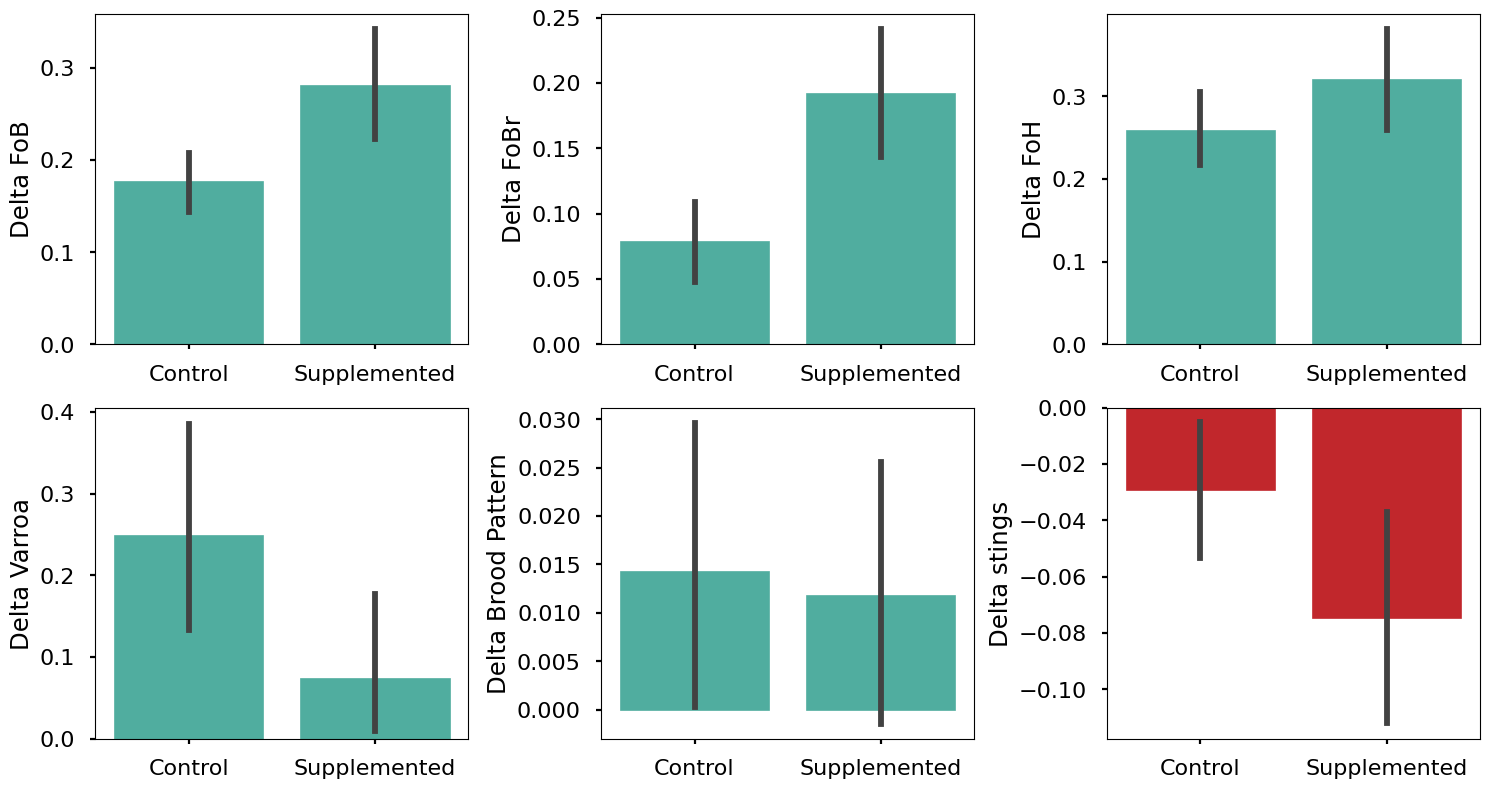

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
cols = ['delta_fob','delta_fobr','delta_foh','delta_varroa',
        'delta_brood_pattern','delta_stings']
names = ["Delta FoB", "Delta FoBr", "Delta FoH", "Delta Varroa","Delta Brood Pattern", "Delta stings"]
for i, (ax,col,nam) in enumerate(zip(axes, cols,names)):
    # bars = ax.bar(data['applied_previous_month'], data[col])
    bars = sns.barplot(x="applied_previous_month",y=col,data=data,ax=ax)
    # av = data.groupby("applied_previous_month")[col].mean()
    ax.set_xlabel("")
    ax.set_ylabel(nam)
    # Color bars based on values
    for bar in bars.containers[0].get_children():
        if bar.get_height() < 0:
            bar.set_color('#c1272c')
        elif bar.get_height() > 0:
            bar.set_color('#50ad9f')
        # Optional: handle zero values
        else:
            bar.set_color('gray')

        
    
# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("Delta-HiveAttribute.png")

In [19]:
data['applied_previous_month'] = data['applied_previous_month'].apply(lambda x: 1 if x =="Supplemented" else 0)

In [38]:
X2 = sm.add_constant(data[['applied_previous_month','hid']].astype(int))
est = sm.OLS(data['delta_fob'], X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_fob   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     19.72
Date:                Tue, 11 Nov 2025   Prob (F-statistic):           3.14e-09
Time:                        00:20:53   Log-Likelihood:                -3460.7
No. Observations:                2820   AIC:                             6927.
Df Residuals:                    2817   BIC:                             6945.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [37]:
X2 = sm.add_constant(data[['applied_previous_month','hid']].astype(int))
est = sm.OLS(data['delta_fobr'], X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             delta_fobr   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     15.50
Date:                Tue, 11 Nov 2025   Prob (F-statistic):           2.01e-07
Time:                        00:20:45   Log-Likelihood:                -3100.6
No. Observations:                2820   AIC:                             6207.
Df Residuals:                    2817   BIC:                             6225.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [36]:
X2 = sm.add_constant(data[['applied_previous_month','hid']].astype(int))
est = sm.OLS(data['delta_varroa'], X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           delta_varroa   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.803
Date:                Tue, 11 Nov 2025   Prob (F-statistic):            0.00827
Time:                        00:20:40   Log-Likelihood:                -6354.5
No. Observations:                2820   AIC:                         1.271e+04
Df Residuals:                    2817   BIC:                         1.273e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [35]:
X2 = sm.add_constant(data[['applied_previous_month','hid']].astype(int))
est = sm.OLS(data['delta_brood_pattern'] , X2)
est2 = est.fit()
print(est2.summary())

                             OLS Regression Results                            
Dep. Variable:     delta_brood_pattern   R-squared:                       0.001
Model:                             OLS   Adj. R-squared:                  0.000
Method:                  Least Squares   F-statistic:                     1.658
Date:                 Tue, 11 Nov 2025   Prob (F-statistic):              0.191
Time:                         00:20:34   Log-Likelihood:                -342.14
No. Observations:                 2820   AIC:                             690.3
Df Residuals:                     2817   BIC:                             708.1
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const             

In [34]:
X2 = sm.add_constant(data[['applied_previous_month','hid']].astype(int))
est = sm.OLS(data['delta_stings'] , X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           delta_stings   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.111
Date:                Tue, 11 Nov 2025   Prob (F-statistic):             0.0165
Time:                        00:20:25   Log-Likelihood:                -2322.2
No. Observations:                2820   AIC:                             4650.
Df Residuals:                    2817   BIC:                             4668.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

In [40]:
import statsmodels.formula.api as smf

In [53]:
model_lmm = smf.mixedlm('delta_fob ~ applied_previous_month', data=data, groups='hid').fit()

In [54]:
print(model_lmm.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   delta_fob 
No. Observations:    2820      Method:               REML      
No. Groups:          307       Scale:                0.6731    
Min. group size:     2         Log-Likelihood:       -3477.6761
Max. group size:     33        Converged:            Yes       
Mean group size:     9.2                                       
---------------------------------------------------------------
                       Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept              0.176    0.022 8.114 0.000  0.133  0.218
applied_previous_month 0.095    0.033 2.902 0.004  0.031  0.159
hid Var                0.016    0.009                          



In [55]:
print(model_lmm.summary().as_latex())

\begin{table}
\caption{Mixed Linear Model Regression Results}
\label{}
\begin{center}
\begin{tabular}{llll}
\hline
Model:            & MixedLM & Dependent Variable: & delta\_fob  \\
No. Observations: & 2820    & Method:             & REML        \\
No. Groups:       & 307     & Scale:              & 0.6731      \\
Min. group size:  & 2       & Log-Likelihood:     & -3477.6761  \\
Max. group size:  & 33      & Converged:          & Yes         \\
Mean group size:  & 9.2     &                     &             \\
\hline
\end{tabular}
\end{center}

\begin{center}
\begin{tabular}{lrrrrrr}
\hline
                         & Coef. & Std.Err. &     z & P$> |$z$|$ & [0.025 & 0.975]  \\
\hline
Intercept                & 0.176 &    0.022 & 8.114 &       0.000 &  0.133 &  0.218  \\
applied\_previous\_month & 0.095 &    0.033 & 2.902 &       0.004 &  0.031 &  0.159  \\
hid Var                  & 0.016 &    0.009 &       &             &        &         \\
\hline
\end{tabular}
\end{center}
\end{tabl

In [56]:
model_lmm = smf.mixedlm('delta_fobr ~ applied_previous_month', data=data, groups='hid').fit()
print(model_lmm.summary())
print(model_lmm.summary().as_latex())

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   delta_fobr
No. Observations:    2820      Method:               REML      
No. Groups:          307       Scale:                0.5199    
Min. group size:     2         Log-Likelihood:       -3111.0948
Max. group size:     33        Converged:            Yes       
Mean group size:     9.2                                       
---------------------------------------------------------------
                       Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept              0.076    0.019 4.026 0.000  0.039  0.113
applied_previous_month 0.114    0.029 3.977 0.000  0.058  0.170
hid Var                0.011    0.008                          

\begin{table}
\caption{Mixed Linear Model Regression Results}
\label{}
\begin{center}
\begin{tabular}{llll}
\hline
Model:            & MixedLM & Dependent Variable: & delta\_fobr  

In [59]:
model_lmm = smf.mixedlm('delta_varroa ~ applied_previous_month', data=data, groups='hid').fit()
print(model_lmm.summary())
print(model_lmm.summary().as_latex())

/Users/nico/Library/Caches/pypoetry/virtualenvs/cubee-YeWUf-Zc-py3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nico/Library/Caches/pypoetry/virtualenvs/cubee-YeWUf-Zc-py3.11/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nico/Library/Caches/pypoetry/virtualenvs/cubee-YeWUf-Zc-py3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nico/Library/Caches/pypoetry/virtualenvs/cubee-YeWUf-Zc-py3.11/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  

              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   delta_varroa
No. Observations:    2820      Method:               REML        
No. Groups:          307       Scale:                5.0818      
Min. group size:     2         Log-Likelihood:       -6350.6103  
Max. group size:     33        Converged:            No          
Mean group size:     9.2                                         
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.267    0.064  4.196 0.000  0.142  0.392
applied_previous_month -0.184    0.092 -2.008 0.045 -0.363 -0.004
hid Var                 0.248    0.035                           

\begin{table}
\caption{Mixed Linear Model Regression Results}
\label{}
\begin{center}
\begin{tabular}{llll}
\hline
Model:            & MixedLM & Dependent 

/Users/nico/Library/Caches/pypoetry/virtualenvs/cubee-YeWUf-Zc-py3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nico/Library/Caches/pypoetry/virtualenvs/cubee-YeWUf-Zc-py3.11/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/nico/Library/Caches/pypoetry/virtualenvs/cubee-YeWUf-Zc-py3.11/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 33.238365
  warnings.warn(msg, ConvergenceWarning)


In [58]:
model_lmm = smf.mixedlm('delta_stings ~ applied_previous_month', data=data, groups='hid').fit()
print(model_lmm.summary())
print(model_lmm.summary().as_latex())

              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   delta_stings
No. Observations:    2820      Method:               REML        
No. Groups:          307       Scale:                0.2967      
Min. group size:     2         Log-Likelihood:       -2325.3141  
Max. group size:     33        Converged:            Yes         
Mean group size:     9.2                                         
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              -0.026    0.014 -1.788 0.074 -0.054  0.002
applied_previous_month -0.042    0.022 -1.956 0.050 -0.085  0.000
hid Var                 0.008    0.005                           

\begin{table}
\caption{Mixed Linear Model Regression Results}
\label{}
\begin{center}
\begin{tabular}{llll}
\hline
Model:            & MixedLM & Dependent 

/Users/nico/Library/Caches/pypoetry/virtualenvs/cubee-YeWUf-Zc-py3.11/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [60]:
model_lmm = smf.mixedlm('delta_brood_pattern ~ applied_previous_month', data=data, groups='hid').fit()
print(model_lmm.summary())
print(model_lmm.summary().as_latex())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: delta_brood_pattern
No. Observations: 2820    Method:             REML               
No. Groups:       307     Scale:              0.0717             
Min. group size:  2       Log-Likelihood:     -343.2406          
Max. group size:  33      Converged:          Yes                
Mean group size:  9.2                                            
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.014    0.007  1.909 0.056 -0.000  0.029
applied_previous_month -0.006    0.011 -0.525 0.600 -0.027  0.016
hid Var                 0.003    0.004                           

\begin{table}
\caption{Mixed Linear Model Regression Results}
\label{}
\begin{center}
\begin{tabular}{llll}
\hline
Model:            & MixedLM & Dependent 

/Users/nico/Library/Caches/pypoetry/virtualenvs/cubee-YeWUf-Zc-py3.11/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [50]:
model_lmm = smf.mixedlm('delta_foh ~ applied_previous_month', data=data, groups='hid').fit()
print(model_lmm.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   delta_foh 
No. Observations:    2820      Method:               REML      
No. Groups:          307       Scale:                0.9512    
Min. group size:     2         Log-Likelihood:       -3972.7851
Max. group size:     33        Converged:            Yes       
Mean group size:     9.2                                       
---------------------------------------------------------------
                       Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept              0.248    0.026 9.386 0.000  0.196  0.300
applied_previous_month 0.058    0.039 1.497 0.134 -0.018  0.135
hid Var                0.030    0.011                          



In [52]:
print(model_lmm.summary().as_latex())

\begin{table}
\caption{Mixed Linear Model Regression Results}
\label{}
\begin{center}
\begin{tabular}{llll}
\hline
Model:            & MixedLM & Dependent Variable: & delta\_foh  \\
No. Observations: & 2820    & Method:             & REML        \\
No. Groups:       & 307     & Scale:              & 0.9512      \\
Min. group size:  & 2       & Log-Likelihood:     & -3972.7851  \\
Max. group size:  & 33      & Converged:          & Yes         \\
Mean group size:  & 9.2     &                     &             \\
\hline
\end{tabular}
\end{center}

\begin{center}
\begin{tabular}{lrrrrrr}
\hline
                         & Coef. & Std.Err. &     z & P$> |$z$|$ & [0.025 & 0.975]  \\
\hline
Intercept                & 0.248 &    0.026 & 9.386 &       0.000 &  0.196 &  0.300  \\
applied\_previous\_month & 0.058 &    0.039 & 1.497 &       0.134 & -0.018 &  0.135  \\
hid Var                  & 0.030 &    0.011 &       &             &        &         \\
\hline
\end{tabular}
\end{center}
\end{tabl